In [1]:
import jax.numpy as np
from neural_tangents import stax
import neural_tangents as nt
from jax import random, jit, vmap

import cnn_gp

import torchvision
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class config:
    train_range = range(40000)
    validation_range = range(40000, 50000)
    test_range = range(50000, 60000)
    transforms = []
    dataset_name = "CIFAR10"
    dataset = torchvision.datasets.CIFAR10
dataset = cnn_gp.DatasetFromConfig("/scratch/ag919/datasets", config)

Files already downloaded and verified


In [3]:
diag_iter = cnn_gp.DiagIterator(2000, dataset.train)
(_same, (_i, (x, y)), _ixy) = next(iter(diag_iter))

In [4]:
x = np.array(x.numpy())

In [5]:
def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(32 * k)),
      WideResnetGroup(block_size, int(32 * k)),
      WideResnetGroup(block_size, int(32 * k)),
      WideResnetGroup(block_size, int(32 * k)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k)),
      WideResnetGroup(block_size, int(64 * k)),
      WideResnetGroup(block_size, int(64 * k)),
      WideResnetGroup(block_size, int(64 * k)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))

init_fn, apply_fn, kernel_fn = WideResnet(block_size=4, k=5, num_classes=10)

In [6]:
init_fn = jit(init_fn, static_argnums=(1,))
apply_fn = jit(apply_fn)

In [7]:
key = random.PRNGKey(4)
_, params = init_fn(key, (-1, 32, 32, 3))

In [8]:
x_nhwc = np.transpose(x, [0, 2, 3, 1])

In [9]:
y = apply_fn(params, x_nhwc)

In [12]:
def count_classes(y):
    return (y.argmax(1) == np.arange(10)[:, None]).sum(1)    
class_df['train5'] = count_classes(y)


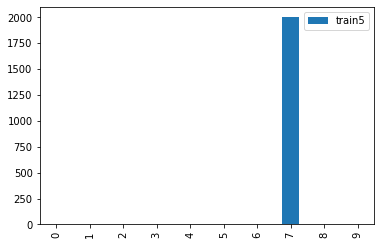

In [13]:
class_df.plot(kind='bar')

In [11]:
class_df = pd.DataFrame(index=np.arange(10))


In [ ]:
n_layers = 10

layers = []
for _ in range(n_layers):
    layers += [stax.Dense(1000, W_std=2.**.5, b_std=.1), stax.Relu()]
layers += [stax.Dense(1)]
    
init_fn, apply_fn, kernel_fn = stax.serial(*layers)
init_fn = jit(init_fn, static_argnums=(1,))
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [ ]:
layers_bn = []
for _ in range(n_layers):
    layers_bn += [stax.Dense(30, W_std=2.**.5, b_std=0.1), stax.BatchNorm(0, center=True, scale=True), stax.Relu()]
layers_bn += [stax.Dense(1)]
    
init_fn_bn, apply_fn_bn, kernel_fn_bn = stax.serial(*layers_bn)
init_fn_bn = jit(init_fn_bn, static_argnums=(1,))
apply_fn_bn = jit(apply_fn_bn)

In [ ]:
xs = np.concatenate([np.linspace(-3, -0.1, 70), np.linspace(-.1, .1, 500), np.linspace(.1, 3, 70)])[:, None].astype('float32')

In [ ]:
key = random.PRNGKey(5)
key, *keys = random.split(key, 10)

idx = np.array([len(xs)//2 + 70, len(xs)//2 + 10])
print("getting for", xs[idx])
scatter_ys = []

mom1 = np.zeros_like(xs)
mom2 = np.zeros((xs.shape[0], xs.shape[0]))

_, ax = plt.subplots(1, 1, figsize=(15, 10))

for k in keys:
    _, w = init_fn(k, (-1, 1))
    ys = apply_fn(w, xs)
    mom1 += ys
    mom2 += ys*ys.T
    scatter_ys.append(ys[idx])
    ax.plot(xs, ys, color='C0')
    
    #for i in range(n_layers):
    #    w.insert(i*3+1, (np.zeros((1)), np.zeros((1))))
    #w_bn = w
    _, w_bn = init_fn_bn(k, (-1, 1))
    ax.plot(xs, apply_fn_bn(w_bn, xs), color='C1')

In [ ]:
len

In [ ]:
scatter_ys = np.stack(scatter_ys)

plt.plot(scatter_ys[:, 0, 0], scatter_ys[:, 1, 0], '+')

In [ ]:
cov = mom2/200 - (mom1/200)*(mom1.T/200)

In [ ]:
#cov = kernel_fn(xs, xs, 'nngp')

kernel_fn = nt.empirical_kernel_fn(apply_fn)
var = np.diag(cov)
corr = cov * (var[:, None] * var)**-.5

plt.imshow(corr)
plt.colorbar()

In [ ]:
var = np.diag(cov)
corr = cov * (var[:, None] * var)**-.5

plt.imshow(corr)
plt.colorbar()

In [ ]:
ys